#### 👕 클로젯셰어 과제 가이드라인 
- 분석 자료 : 최근 3개월간 신규 구매 데이터 일부

- 분석 필요 내용


**1. 구매 소요 시간 분석**


    1-1. 가입일로부터 구매일까지 전환된 소요시간 분석
        - 최근 3개월 전체 분석 / 각 월 별 분석
        - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
            ex. 가입 1일 이내 전환 유저 : 10% -> 15% 상승 성과

**2. 구매 상품 트렌드 분석**
 
     2-1. 유저당 주문 수량 분석
         - 최근 3개월 전체 분석 / 각 월 별 분석
         - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석
     2-2. 주문 아이템 분석
         - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
         - 신규 유저들의 구매 트렌드 파악

**3. 분석 내용 토대로 인사이트 도출**

    3-1. 분석 내용 도식화
        - 1~2의 분석 내용 종합 및 도식화 (표 또는 그래프)
        - 유사성을 갖는 결과에 대하여 그룹화
    3-2. 인사이트 도출
        - 해당 결과를 통해 나타나는 사항 정리
        - 인사이트 도출 혹은 새로운 제안사항 전달 (없을 시 진행하지 않아도 무방)

- 분석 참고 사항

  1. 용어 및 칼럼 설명
     brandnm : 아이템 브랜드명
     goodsnm : 아이템 명
     USER : 개별 유저 식별 값
     reg_date : 개별 유저 가입일
     order_date : 아이템 주문일
     p_type : 주문 상품 종류
             7days (7일권) / 4days (4일권)
     sub_type : 주문 상품 카테고리 
               BA – 가방 / O – 아우터 / D – 드레스 / T – 상의 / B – 하의 / TB – 투피스 
     app_yn : 어플리케이션 사용 여부
              Y – 어플리케이션 사용 / (공백) – 어플리케이션 미사용
    

#### 모듈 import

In [189]:
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style(style="white")
plt.rc('font', family='Malgun Gothic') 
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.unicode_minus'] = False    # minus

from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles

# interactive
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 노트북 세팅
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

# 연관분석
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

#### Data import

##### 과제 data

In [406]:
# 과제 data
closet = pd.read_excel('../week3/클로젯셰어_과제DB 대체 자료.xlsx',)
df = closet.copy()
# col > lower
df.columns=list(map(lambda x: x.lower(),df.columns))

In [407]:
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [408]:
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y


##### 외부 data

In [409]:
# 크롤링 data 가격정보
price = pd.read_excel('../week3/tag_price_df.xlsx')
# remove space
price.columns=list(map(lambda x: x.replace(' ',''),price.columns))
price=price.iloc[:,1:]
price.head(2)

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00


### 데이터 개요

In [344]:
df.head(5)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,NaN,2020,08,2020-08,5.00,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,Y,2020,04,2020-04,4.00,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,Y,2020,04,2020-04,4.00,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,NaN,2020,12,2020-12,3.00,1,53,5,0


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brandnm          1442 non-null   object 
 1   goodsnm          1471 non-null   object 
 2   user             1471 non-null   object 
 3   reg_date         1466 non-null   object 
 4   order_date       1471 non-null   object 
 5   p_type           1471 non-null   object 
 6   sub_type         1471 non-null   object 
 7   app_yn           1295 non-null   object 
 8   reg_year         1466 non-null   object 
 9   reg_month        1466 non-null   object 
 10  reg_yearmonth    1466 non-null   object 
 11  reg_dayofweek    1466 non-null   float64
 12  order_month      1471 non-null   int64  
 13  order_week       1471 non-null   int64  
 14  order_dayofweek  1471 non-null   int64  
 15  brandnm_luxury   1471 non-null   int32  
dtypes: float64(1), int32(1), int64(3), object(11)
memory usage: 

In [346]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
reg_dayofweek,1466.00,2.71,1.98,0.00,1.00,2.00,4.00,6.00
order_month,1471.00,2.18,0.81,1.00,1.00,2.00,3.00,3.00
order_week,1471.00,7.88,5.28,1.00,5.00,8.00,11.00,53.00
order_dayofweek,1471.00,2.39,1.68,0.00,1.00,2.00,3.00,6.00
brandnm_luxury,1471.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00


In [355]:
price.head() 

,brandnm,goodsnm,tag,4d_price,7d_price
0,Gucci,flower dionysus shoulder bag beige,#위켄드,49000.00,59000.00
1,Gucci,dionysus cross bag,#위켄드,49000.00,59000.00
2,Tory Burch,flower ethnic pattern cross bag white,#위켄드,34000.00,44000.00
3,Chloe,faye small bag black,#오피스 #위켄드,34000.00,44000.00
4,Prada,logo hobo bag black,#일상,39000.00,49000.00


In [356]:
print(price['4d_price'].unique())
print(price['7d_price'].unique())

[49000. 34000. 39000. 59000.    nan 29000. 15000. 24000. 38000. 19000.
 12000.]
[59000. 44000. 49000. 69000.    nan 39000. 25000. 34000. 58000. 29000.
 22000.]


In [357]:
price.describe().T

,count,mean,std,min,25%,50%,75%,max
4d_price,540.00,39983.33,10221.74,12000.00,34000.00,39000.00,49000.00,59000.00
7d_price,540.00,50001.85,10227.20,22000.00,44000.00,49000.00,59000.00,69000.00


#### 데이터 개요 정리

In [203]:
print('브랜드 수:', df.brandnm.nunique(),'\n')
print('유저 수:', df.user.nunique(),'\n')
print('구매 타입 수:', df.p_type.nunique())
print('구매 타입 수:', df.p_type.unique(),'\n')
print('서브 타입 수:', df.sub_type.nunique())
print('서브 타입 수:', df.sub_type.unique(),'\n')
print('가입 정보 기간:', pd.to_datetime(df['reg_date']).min() ,"~", pd.to_datetime(df['reg_date']).max())
print('구매 정보 기간:', df.order_date.min() ,"~", df.order_date.max())

브랜드 수: 245 

유저 수: 1234 

구매 타입 수: 2
구매 타입 수: ['7days' '4days'] 

서브 타입 수: 6
서브 타입 수: ['O' 'D' 'BA' 'T' 'B' 'TP'] 

가입 정보 기간: 2017-06-24 00:00:00 ~ 2021-03-31 00:00:00
구매 정보 기간: 2021-01-01 ~ 2021-03-31


In [204]:
df.sub_type.unique()

array(['O', 'D', 'BA', 'T', 'B', 'TP'], dtype=object)

In [205]:
df.groupby('user')['order_date'].count().sort_values()

user
a1146892    1 
a1148775    1 
a1148769    1 
a1148768    1 
a1148750    1 
           .. 
a189404     7 
a1143701    7 
a1142677    9 
a1149583    10
a1149461    11
Name: order_date, Length: 1234, dtype: int64

In [206]:
# 1회 주문 건수 11회인 유저 : reg date과 order date 차이 2일 > 신규 유저 이벤트?
df.query('user=="a1149461"')

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
1128,Alice & Olivia,see-through lace detail blouse black,a1149461,2021-03-15,2021-03-17,4days,T,NaN,2021,03,2021-03,0.00,3,11,2,0
1129,Sandro,embroidery detail lace skirt multi,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0
1130,Time,draping detail midi skirt gray,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0
1131,El estilo de Claire,ruffle detail see-through sleeve blouse black,a1149461,2021-03-15,2021-03-17,4days,T,NaN,2021,03,2021-03,0.00,3,11,2,0
1132,It michaa,pocket basic pattern skirt green,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0
1133,roajeu,ruffle basic pattern mermaid trumpet-skirt green,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0
1134,Alexander Wang,basic pattern skirt grey,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0
1135,Christian Dior,basic pattern sweater burgundy,a1149461,2021-03-15,2021-03-17,4days,T,NaN,2021,03,2021-03,0.00,3,11,2,1
1136,MSGM,basic pattern top black,a1149461,2021-03-15,2021-03-17,4days,T,NaN,2021,03,2021-03,0.00,3,11,2,0
1137,Fayewoo,ruffle lace pattern mermaid trumpet-skirt red,a1149461,2021-03-15,2021-03-17,4days,B,NaN,2021,03,2021-03,0.00,3,11,2,0


In [207]:
df.goodsnm.nunique()

979

In [208]:
brand_list=df.brandnm.value_counts().index.unique()
len(brand_list)

245

In [209]:
brand_list

Index(['Gucci', 'Chanel', 'Saint Laurent', 'Louis Vuitton', 'Prada',
       'Burberry', 'Yves Saint Laurent', 'Thom Browne', 'Fendi', 'Celine',
       ...
       'H&Moschino', 'Overdueflair', 'SDI', 'Armani Collezioni',
       'Paipai jiemei', 'Lafudge Store', 'The Tint', 'Goyard', 'Vanessa Bruno',
       'BEMUSE MANSION'],
      dtype='object', length=245)

### 결측치 확인/처리

In [410]:
df.isnull().sum()

brandnm       29 
goodsnm       0  
user          0  
reg_date      5  
order_date    0  
p_type        0  
sub_type      0  
app_yn        176
dtype: int64

#### brandnm : fillna('N/A')             

In [411]:
df['brandnm'] = df['brandnm'].fillna('N/A')

#### app_yn : fillna(0)  

In [412]:
# app_yn 값 0, 1 치환
df['app_yn'] = df['app_yn'].fillna(0)
df.loc[(df.app_yn == 'Y'), 'app_yn'] = 1

#### reg_date : fillna(method='pad')

In [413]:
# reg_date 순서대로 user의 id가 부여되었는지 확인
reg_user = df[df['reg_date'].notnull()].sort_values('user').sort_values('reg_date').reset_index().iloc[:,3:5]
print(reg_user)

for i in np.arange(0,len(reg_user)-1):
    if int(reg_user.user[i][1:]) > int(reg_user.user[i+1][1:]):
        
        if reg_user.reg_date[i] != reg_user.reg_date[i+1]:
            print("순서대로 부여되지 않았습니다.")

print("")
print("user의 id는 reg_date의 순서대로 부여되었다.")

          user   reg_date
0     a11612   2017-06-24
1     a11803   2017-07-02
2     a13637   2018-03-09
3     a13741   2018-03-20
4     a13934   2018-03-27
...      ...          ...
1461  a1151479 2021-03-31
1462  a1151481 2021-03-31
1463  a1151496 2021-03-31
1464  a1151499 2021-03-31
1465  a1151564 2021-03-31

[1466 rows x 2 columns]

user의 id는 reg_date의 순서대로 부여되었다.


In [414]:
# reg date null 처리를 위해
df = df.sort_values(['user','reg_date'])
df['reg_date']=df['reg_date'].fillna(method = 'pad')

In [415]:
# order_date, user 기준 재정렬 
df = df.sort_values(['order_date','user']).reset_index(drop=True)

In [416]:
#df.query('(user == "a1144008")|(user == "a1142855")|(user == "a1146490")|(user == "a1145478")|(user == "a1149094")')
df.isnull().sum()

brandnm       0
goodsnm       0
user          0
reg_date      0
order_date    0
p_type        0
sub_type      0
app_yn        0
dtype: int64

In [417]:
# 가입 정보 관련 날짜 변수 추가 
df['reg_date']=pd.to_datetime(df['reg_date'])
df['reg_year']=df['reg_date'].dt.strftime('%Y')
df['reg_month']=df['reg_date'].dt.strftime('%m')
df['reg_yearmonth']=df['reg_date'].dt.strftime('%Y-%m')
df['reg_dayofweek']=df['reg_date'].dt.dayofweek
df['order_month']=df['order_date'].dt.month
df['order_week']=df['order_date'].dt.week
df['order_dayofweek']=df['order_date'].dt.dayofweek
# date continuous변환
df['order_date']=pd.to_datetime(df['order_date']).dt.date
df['reg_date']=pd.to_datetime(df['reg_date']).dt.date

In [418]:
# 2021 top 10 list
luxury_list=['GUCCI','Louis Vuitton','Cartier','Chanel','Hermes','Ferrari','Rolex','Dior','Christian Dior','COACH','Estee Lauder','Tiffany & Co.',
'Guerlain','Burberry','Prada','Lancôme','Omega','Clarins','Bulgari','Moncler','Saint Laurent','SK-II','McLaren','TAG Heuer','Givenchy','Lamborghini','Armani','Bottega Veneta','Rolls- Royce',
'Bentley','Aston Martin','Loewe','Maserati','Van Cleef & Arpels','Valentino','Salvatore Ferragamo','Shiseido','Sulwhasoo','Tissot','Versace','Bobbi Brown','Montblanc','Tom Ford','Longines','Cle de Peau Beaute','Jaeger-LeCoultre',
'Celine','Dolce & Gabbana','Miu Miu','Fendi']
# brandnm luxury 
luxury_list_lower = []

for item in luxury_list:
  item = item.lower()
  luxury_list_lower.append(item)

# brandnm luxury 
df['brandnm_luxury']=np.where(df['brandnm'].str.lower().isin(luxury_list_lower), 1,0)
df.head()

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,0,2020,08,2020-08,5,1,53,4,1
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,1,2020,04,2020-04,4,1,53,4,0
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,2020-04,4,1,53,4,0
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,2020-04,4,1,53,4,0
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,0,2020,12,2020-12,3,1,53,5,0


### 추가 테이블 생성

- df_user 기본 정보 테이블 생성 (column 별 count)

In [524]:
# df_user 유저 기본 정보 테이블생성
df_user = df.groupby(['user','reg_date','reg_yearmonth','order_date','order_month','order_week','order_dayofweek'])['goodsnm'].count().to_frame().reset_index().rename(columns={'goodsnm':'order_count'}) 
ptype = df.pivot_table(index='user', columns='p_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
subtype = df.pivot_table(index='user', columns='sub_type',values= 'order_date',aggfunc='count').fillna(0).reset_index()
app = df.pivot_table(index='user', columns='app_yn',values= 'order_date',aggfunc='count').fillna(0).reset_index().rename(columns={'Y':'app'}) 

# merge
df_user = df_user.merge(ptype, how='left', on='user').merge(app, how='left', on='user').merge(luxury, how='left', on='user').merge(subtype, how='left', on='user').fillna(0)
df_user.head(5)

,user,reg_date,reg_yearmonth,order_date,order_month,order_week,order_dayofweek,order_count,4days,7days,0,1,brandnm_luxury,B,BA,D,O,T,TP
0,a1100548,2020-05-16,2020-05,2021-03-31,3,13,2,2,2.00,0.00,0.00,2.00,0,1.00,1.00,0.00,0.00,0.00,0.00
1,a1100887,2020-05-19,2020-05,2021-03-29,3,13,0,1,0.00,1.00,0.00,1.00,0,0.00,1.00,0.00,0.00,0.00,0.00
2,a1101514,2020-05-25,2020-05,2021-02-05,2,5,4,1,1.00,0.00,0.00,1.00,0,0.00,0.00,0.00,1.00,0.00,0.00
3,a1101645,2020-05-26,2020-05,2021-02-23,2,8,1,1,1.00,0.00,1.00,0.00,0,0.00,1.00,0.00,0.00,0.00,0.00
4,a1102068,2020-05-29,2020-05,2021-03-04,3,9,3,1,0.00,1.00,0.00,1.00,0,0.00,1.00,0.00,0.00,0.00,0.00


### EDA 
**2. 구매 상품 트렌드 분석**
 
1. 유저당 주문 수량 분석
    > - 최근 3개월 전체 분석 / 각 월 별 분석 
    > - 분기 경향 / 월 별 변동사항 확인 -> 트렌드 분석

2. 주문 아이템 분석
    > - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
    > - 신규 유저들의 구매 트렌드 파악


#### 주문 수량 분석

##### 최근 3개월 전체 분석

###### 전체 유저

In [420]:
px.bar(df_user.groupby('order_date').sum(),y='order_count',title='Daily 주문 수량',width=700, height=400)

In [421]:
px.bar(df_user.groupby('order_week').sum(), y='order_count', title='weekly 주문 수량', width=700, height=400)

In [220]:
px.bar(df_user.groupby('order_month').sum(), y='order_count', title='monthly 주문 수량', width=700, height=400)

In [422]:
px.bar(df_user.groupby('order_dayofweek').sum(), y='order_count',title='요일별 주문 수량', width=500, height=400)

- 주말에 급하락, 수요일마다 급상승하는 분포의 반복
- 3월에 집중

###### 가입기간 기준 코호트별

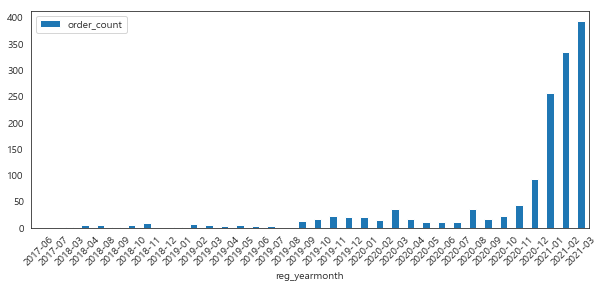

In [423]:
df_user.groupby('reg_yearmonth').sum().reset_index().plot.bar(x='reg_yearmonth', y='order_count', rot=45, figsize=(10,4))

- 가입 시기 최근 집단일수록 2021.01-03 주문량 많음

###### 자주 구매하는 카테고리 기준 코호트별

  index  sub_type
0  BA    692     
1  O     267     
2  D     261     
3  T     164     
4  B     58      
5  TP    29      
전체 % 
 BA   0.47
O    0.18
D    0.18
T    0.11
B    0.04
TP   0.02
Name: sub_type, dtype: float64


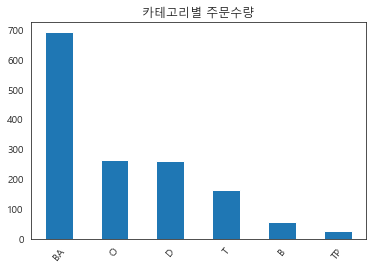

In [424]:
# 카테고리별 주문 수량
print(df.sub_type.value_counts().sort_values(ascending=False).reset_index())
print('전체 % \n',(df.sub_type.value_counts().sort_values(ascending=False)/ df.sub_type.value_counts().sum()))
df.sub_type.value_counts().sort_values(ascending=False).plot.bar(figsize=(6,4),rot=50, title='카테고리별 주문수량')

In [425]:
df.sub_type.value_counts().sum()

1471

In [426]:
df_user[['B','BA','D','O','T','TP']].describe().T

,count,mean,std,min,25%,50%,75%,max
B,1234.00,0.05,0.29,0.00,0.00,0.00,0.00,6.00
BA,1234.00,0.56,0.50,0.00,0.00,1.00,1.00,2.00
D,1234.00,0.21,0.52,0.00,0.00,0.00,0.00,6.00
O,1234.00,0.22,0.43,0.00,0.00,0.00,0.00,2.00
T,1234.00,0.13,0.47,0.00,0.00,0.00,0.00,8.00
TP,1234.00,0.02,0.16,0.00,0.00,0.00,0.00,2.00


In [427]:
# 유저가 대여시, 한번에 한 카테고리 집중된 케이스 : B, D, T 
df[df.user.isin(df_user.query('(B==6)|(D==6)|(T==8)').user.to_list())]

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury
151,Vivienne Westwood,basic pattern t-shirts lavender,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
152,Greedilous,graphics pattern t-shirts yellow,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
153,System homme,pocket stripe pattern shirts pink,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
154,Covernat,button check pattern shirts mustard,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
155,Musinsa standard,button basic pattern shirts deeppink,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
156,Musinsa standard,button basic pattern polo-shirts beige,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
157,Lafudge Store,pocket basic pattern top beige,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
158,Calvin Klein,pocket basic pattern wool slacks grey,a1142677,2021-01-13,2021-01-18,4days,B,1,2021,01,2021-01,2,1,3,0,0
159,Massimo Dutti,pocket basic pattern shirts mint,a1142677,2021-01-13,2021-01-18,4days,T,1,2021,01,2021-01,2,1,3,0,0
1128,Alice & Olivia,see-through lace detail blouse black,a1149461,2021-03-15,2021-03-17,4days,T,0,2021,03,2021-03,0,3,11,2,0


- 가방(BA)이 압도적으로 많음 
- 유저가 대여시, 한번에 한 카테고리 집중된 케이스 : B, D, T
    - p_type 4일권
    - 가입월 = 주문월, 차이 일주일 미만 : 신규 유저 이벤트?

#### 주문 아이템 분석
- 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
- 신규 유저들의 구매 트렌드 파악

##### 브랜드/카테고리별 선호도 

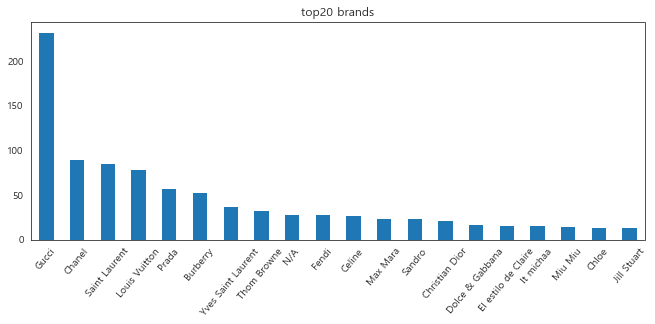

In [428]:
df.brandnm.value_counts().sort_values(ascending=False).head(20).plot.bar(figsize=(11,4),rot=50, title='top20 brands')

In [429]:
# gucci 대여 user 함께 대여한 브랜드 특별한 특징 없음 
df[df.user.isin(df.query('brandnm=="Gucci"')['user'].tolist())]['brandnm'].value_counts()

Gucci                  232
Thom Browne            2  
Max Mara               1  
El estilo de Claire    1  
Kenzo                  1  
L’ vir                 1  
Burberry               1  
Lenic & Mccoy          1  
Time homme             1  
Chanel                 1  
Givenchy               1  
Yves Saint Laurent     1  
Time                   1  
Celine                 1  
Dolce & Gabbana        1  
Vivienne Westwood      1  
Carven                 1  
Moncler                1  
Mojosphine             1  
Heohwan Simulation     1  
Dewl                   1  
Name: brandnm, dtype: int64

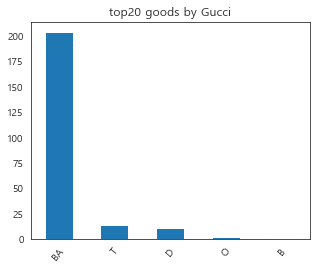

In [430]:
df.query('brandnm=="Gucci"').sub_type.value_counts().sort_values(ascending=False).head(20).plot.bar(figsize=(5,4),rot=50, title='top20 goods by Gucci')

- top 20 브랜드 대부분 명품/고가 브랜드
- 특정 브랜드 집중 : Gucci 가방

##### 신규 유저들의 구매 트렌드 파악 
- seg_new (binary) 신규유저 구분자 : 2021-01~03 가입자

In [525]:
new_list = df.query('(reg_yearmonth=="2021-01") |(reg_yearmonth=="2021-02")|(reg_yearmonth=="2021-03")').user.tolist()
df['seg_new'] = np.where(df.user.isin(new_list), 1, 0)
df.head(2)

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury,seg_new,seg_heavy,lag,lag_month
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,0,2020,08,2020-08,5,1,53,4,1,0,0,139,4.63
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,1,2020,04,2020-04,4,1,53,4,0,0,1,259,8.63


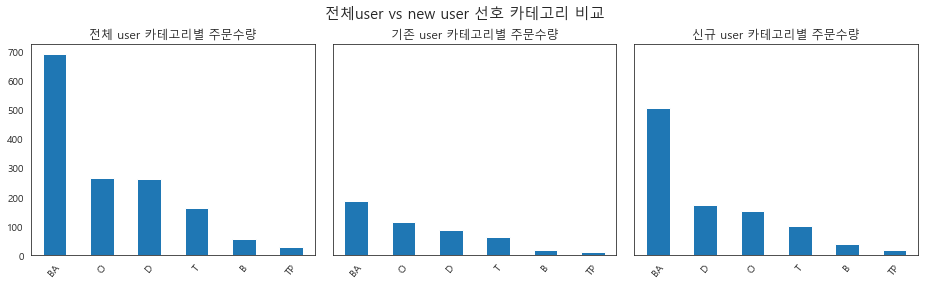

In [432]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(13,4), sharey=True)
fig.suptitle('전체user vs new user 선호 카테고리 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df.query('seg_new==0').sub_type.value_counts().plot.bar(rot=50, title='기존 user 카테고리별 주문수량', ax=axes[1])
df.query('seg_new==1').sub_type.value_counts().plot.bar(rot=50, title='신규 user 카테고리별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

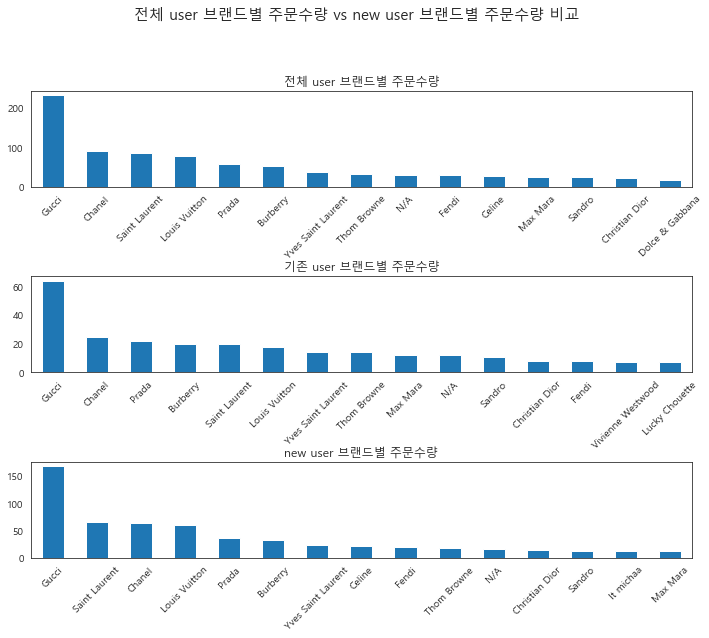

In [433]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,9))
fig.suptitle('전체 user 브랜드별 주문수량 vs new user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='기존 user 브랜드별 주문수량', ax=axes[1])
df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='new user 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

Text(0.5, 1.0, '전체user vs new user 선호 카테고리 비교')

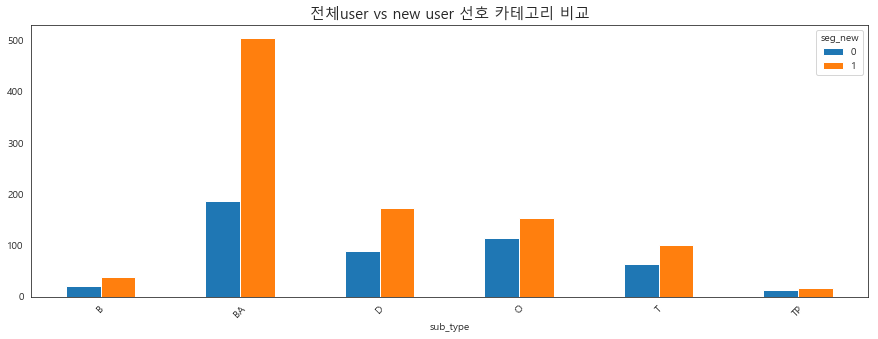

In [434]:
df.pivot_table(index='sub_type', 
               columns ='seg_new', 
               values='order_date', 
            aggfunc='count').fillna(0).plot(kind='bar', rot=45, figsize=(15,5))
plt.title('전체user vs new user 선호 카테고리 비교',fontsize=15)

- 전체 유저의 카테고리별 주문수량 vs 신규 유저 카테고리별 주문수량 트렌드 비교
    1. 전체적인 순위는 유사, BA > O or D > T > B > TB
    2. 신규 유저의 가방 수량 집중현상이 전체에 반영된 것으로 보임


- 전체 user 브랜드별 주문수량 vs 신규유저 브랜드별 주문수량 비교
    1. Gucci 집중은 유사한 형태

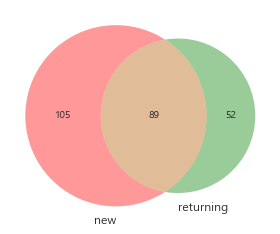

In [435]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(5,4))
venn2([set(df.query('seg_new==1')['brandnm'].tolist()),set(df.query('seg_new==0')['brandnm'].tolist())],
     set_labels = ('new','returning'))
plt.show()

**- 신규유저 vs 기존유저 브랜드 선호도 차이**
1. 신규 유저가 주문한 184개의 브랜드 중 80이 기존 유저와 중복됨 
2. 신규 유저가 주문한 184개의 브랜드 중 104(50%)이 기존 유저와 다름 > 추가로 파악해볼 필요성 있음

In [436]:
new_brand_list = list(set(df.query('seg_new==1')['brandnm'].tolist())-set(df.query('seg_new==0')['brandnm'].tolist()))

Salvatore Ferragamo    9
Mine                   7
Debb                   5
MSGM                   3
Alexander Wang         3
Studio Tomboy          3
Johnny Hates Jazz      3
Banana Republic        3
Olive des Olive        3
Essentiel Antwerp      2
Name: brandnm, dtype: int64


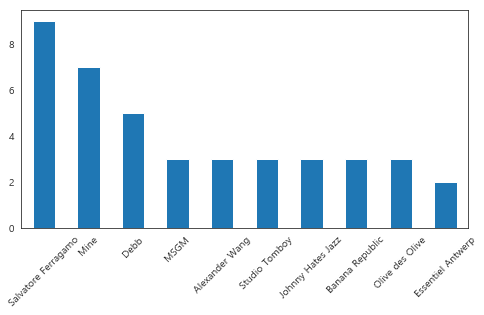

In [437]:
print(df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().head(10))
df[df.brandnm.isin(new_brand_list)].brandnm.value_counts().head(10).plot.bar(rot=45, figsize=(8,4))

- Salvatore Ferragamo
- Mine, Debb
- 상대적으로 덜 고가의 브랜드가 추가됨

##### heavy 유저 

In [438]:
df_user.order_count.describe().T

count   1234.00
mean    1.19   
std     0.73   
min     1.00   
25%     1.00   
50%     1.00   
75%     1.00   
max     11.00  
Name: order_count, dtype: float64

In [439]:
# 2건 이상 heavy user로 규정
heavy_list=df_user.query('order_count>1').user.tolist()
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)

Text(0.5, 1.0, 'non heavy user vs heavy user 가입 월 비교')

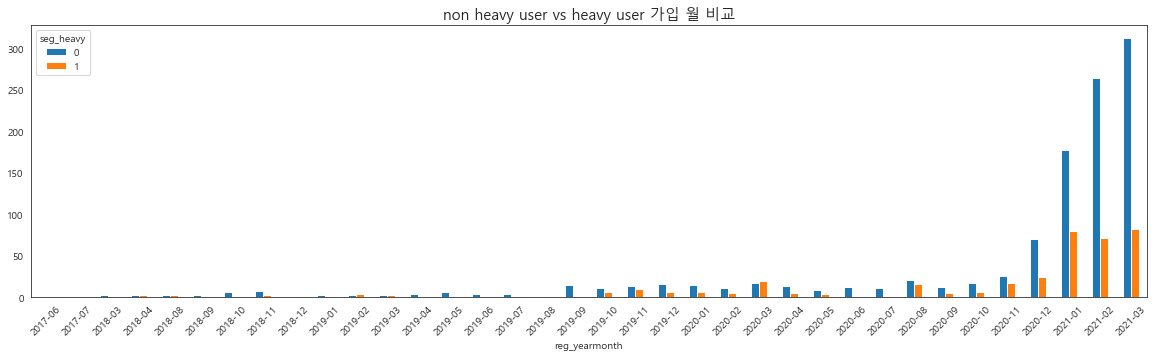

In [440]:
df.pivot_table(index='reg_yearmonth', 
               columns ='seg_heavy', 
               values='order_date', 
            aggfunc='count').fillna(0).plot(kind='bar', rot=45, figsize=(20,5))
plt.title('non heavy user vs heavy user 가입 월 비교',fontsize=15)

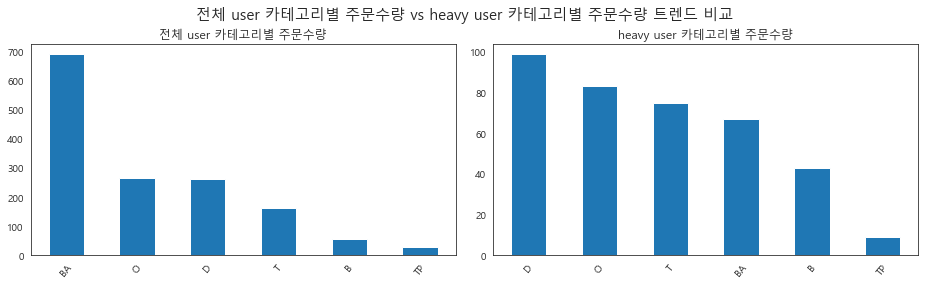

In [441]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
fig.suptitle('전체 user 카테고리별 주문수량 vs heavy user 카테고리별 주문수량 트렌드 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df[df.user.isin(heavy_list)].sub_type.value_counts().plot.bar(rot=50, title='heavy user 카테고리별 주문수량', ax=axes[1])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

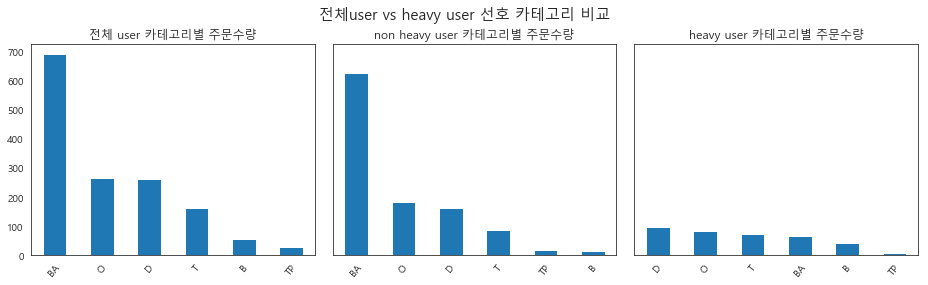

In [442]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(13,4), sharey=True)
fig.suptitle('전체user vs heavy user 선호 카테고리 비교', fontsize=15)
df.sub_type.value_counts().plot.bar(rot=50, title='전체 user 카테고리별 주문수량', ax=axes[0])
df.query('seg_heavy==0').sub_type.value_counts().plot.bar(rot=50, title='non heavy user 카테고리별 주문수량', ax=axes[1])
df.query('seg_heavy==1').sub_type.value_counts().plot.bar(rot=50, title='heavy user 카테고리별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

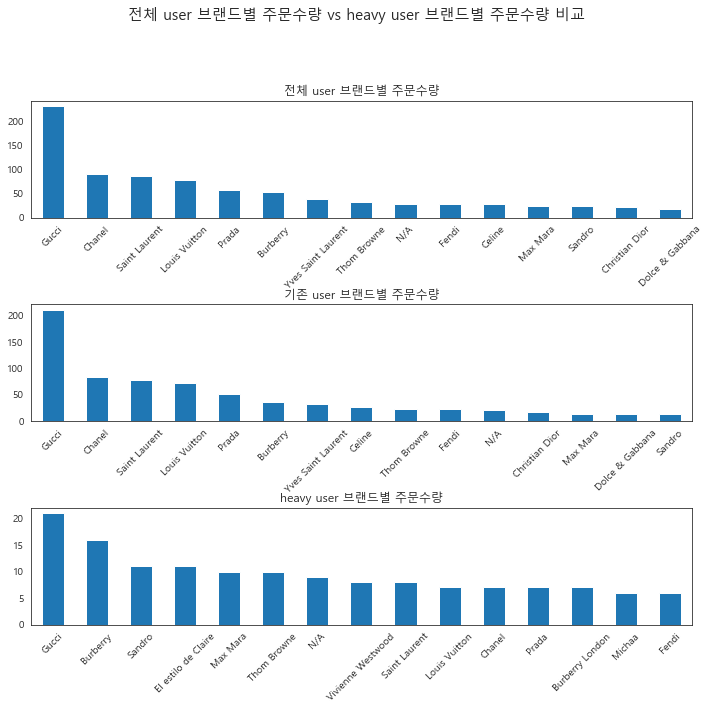

In [443]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
fig.suptitle('전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='기존 user 브랜드별 주문수량', ax=axes[1])
df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).plot.bar(rot=45, title='heavy user 브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

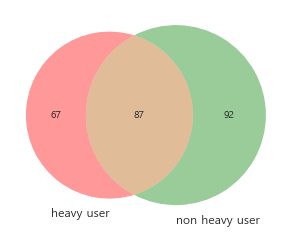

In [444]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(6,4))
venn2([set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).index.tolist()),
       set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).index.tolist())],
     set_labels = ('heavy user','non heavy user'))
plt.show()

- 유저 주문 건수 대부분 1 건 

**Heavy user 구분 기준 주문 수량 2건 이상**

**- 전체 유저의 카테고리별 주문수량 vs heavy user 카테고리별 주문수량 트렌드 비교**
1. 전체 유저 가방이 압도적 : 가방 >>>> 아우터 > 드레스 > 상의 >> 하의 > 투피스
2. heavy user(대여 제품 2건 이상 유저)의 경우 드레스 제일 많음 : 드레스 > 아우터 > 상의 > 가방 > 하의 >>> 투피스


**- 전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교**
1. 브랜드 선호도에는 차이가 있음 (벤다이어그램)
2. 대부분 luxury brand
3. Gucci 집중현상 적음
4. 브랜드 정보 없는 경우 (0) 신규유저/기존유저 50% 50%

In [445]:
heavy_brand_list = list(set(df.query('seg_heavy==1')['brandnm'].tolist())-set(df.query('seg_heavy==0')['brandnm'].tolist()))
len(heavy_brand_list)

67

Amsale              3
Zooc                2
C.holyn             2
DKNY                2
Cesare Paciotti     2
BCBG Max Azria      2
Convexo Concave     2
Musinsa standard    2
Andersson Bell      2
Isabel Marant       2
Name: brandnm, dtype: int64


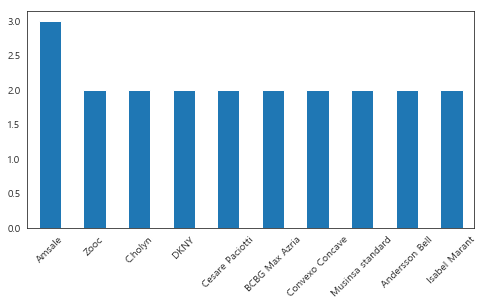

In [446]:
print(df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10))
df[df.brandnm.isin(heavy_brand_list)].brandnm.value_counts().sort_values(ascending=False).head(10).plot.bar(rot=45, figsize=(8,4))

- 높은 건수는 아님
- 고가의 브랜드는 아님

#### 인기 브랜드 분석

1. 집단 구분
    - 신규 유저 vs 기존 유저
    - 헤비 유저 vs non 헤비 유저
    

2. 상기 집단 구분에서 top 15 (주문수량기준) 내 브랜드 추출 후 중복되는 브랜드 : popular_brand_list 집중 분석
    - 명품 브랜드

In [447]:
s1 = set(df.query('seg_new==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s2 = set(df.query('seg_new==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s3 = set(df.query('seg_heavy==1').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
s4 = set(df.query('seg_heavy==0').brandnm.value_counts().sort_values(ascending=False).head(15).index.tolist())
popular_brand_list = list(s1&s2&s3&s4)
len(list(s1&s2&s3&s4))

11

In [448]:
#popular_brand_list.remove("0")
popular_brand_list

['Prada',
 'Thom Browne',
 'Fendi',
 'Burberry',
 'N/A',
 'Max Mara',
 'Chanel',
 'Saint Laurent',
 'Louis Vuitton',
 'Sandro',
 'Gucci']

In [449]:
df[df.brandnm.isin(popular_brand_list)]

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury,seg_new,seg_heavy
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,0,2020,08,2020-08,5,1,53,4,1,0,0
6,Gucci,marmont gg logo quilted bag Black 4,a1127774,2020-10-30,2021-01-03,7days,BA,1,2020,10,2020-10,4,1,53,6,1,0,0
7,Gucci,sylvie mini chain ribbon bag white,a1138262,2020-12-19,2021-01-03,4days,BA,1,2020,12,2020-12,5,1,53,6,1,0,0
11,Max Mara,lace detail crop cardigan black_1,a1119528,2020-09-14,2021-01-04,4days,T,1,2020,09,2020-09,0,1,1,0,0,0,1
13,Burberry,belt basic pattern trench-coat red,a1119528,2020-09-14,2021-01-04,4days,O,1,2020,09,2020-09,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,Gucci,graphics pattern sweat-shirts ivory,a1151496,2021-03-31,2021-03-31,7days,T,1,2021,03,2021-03,2,3,13,2,1,1,0
1462,Gucci,GG supreme clutch brown,a1151499,2021-03-31,2021-03-31,4days,BA,1,2021,03,2021-03,2,3,13,2,1,1,0
1465,Saint Laurent,chevron quilted cross bag black,a125904,2019-05-24,2021-03-31,4days,BA,1,2019,05,2019-05,4,3,13,2,1,0,0
1467,Louis Vuitton,monogram canvas clutch bag,a13741,2018-03-20,2021-03-31,4days,BA,1,2018,03,2018-03,1,3,13,2,1,0,0


#### 연관분석
- http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/
- https://wotres.tistory.com/entry/Association-Rule-%EC%97%B0%EA%B4%80%EC%84%B1-%EB%B6%84%EC%84%9D-in-python
- 지지도 x, y가 함께 발생할 확률 
- 향상도 1 : 품목간 관계 없음, >1 긍정 관계, <1 부정관계
- 신뢰도 : 조건부 확률 x > y

###### 연관분석 모듈 / function

In [450]:
# 연관규칙
def toList(x):
    return list(set(x))

##### 브랜드  
- 지지도 0.2보다 낮아서 사용 X

In [451]:
# 같이 구매한 브랜드 리스트
# 2개 이상 필터링
df_asso=df.groupby('user').brandnm.apply(lambda x : toList(x)).reset_index()
df_asso['len'] = df_asso.brandnm.apply(lambda x: len(x)>=2)
df_asso.head(5)

,user,brandnm,len
0,a1100548,"[Yves Saint Laurent, On&On]",True
1,a1100887,[Gucci],False
2,a1101514,[Max Mara],False
3,a1101645,[Gucci],False
4,a1102068,[Gucci],False


In [452]:
asso_list = list(df_asso.brandnm)

In [453]:
asso_list[:10]

[['Yves Saint Laurent', 'On&On'],
 ['Gucci'],
 ['Max Mara'],
 ['Gucci'],
 ['Gucci'],
 ['Max Mara', 'Chanel'],
 ['Prada'],
 ['Gucci'],
 ['Chanel'],
 ['Yves Saint Laurent']]

In [454]:
#! pip install mlxtend
# 인코딩용
from mlxtend.preprocessing import TransactionEncoder
# 연관분석 
from mlxtend.frequent_patterns import apriori
te=TransactionEncoder() # 객체 생성

In [455]:
asso_list_encoded = te.fit(asso_list).transform(asso_list)
# one hot encoding
asso_list_encoded=asso_list_encoded.astype("int")
df_asso_encoded = pd.DataFrame(asso_list_encoded, columns=te.columns_)

In [456]:
df_asso_encoded.columns

Index(['& Other Stories', 'A BY A', 'A.P.C.', 'ACNE STUDIOS', 'Adidas',
       'Adidas X Stella Mccartney', 'Akro', 'Alexander Mcqueen',
       'Alexander Wang', 'Alice & Olivia',
       ...
       'Wai Kei', 'Wonder Style', 'Your Name Here', 'Yves Saint Laurent',
       'Zadig & Voltaire', 'Zooc', 'cecilie bahnsen', 'khrisjoy', 'roajeu',
       'thom browne'],
      dtype='object', length=246)

In [457]:
df_asso_encoded.head(5)

,& Other Stories,A BY A,A.P.C.,ACNE STUDIOS,Adidas,Adidas X Stella Mccartney,Akro,Alexander Mcqueen,Alexander Wang,Alice & Olivia,...,Wai Kei,Wonder Style,Your Name Here,Yves Saint Laurent,Zadig & Voltaire,Zooc,cecilie bahnsen,khrisjoy,roajeu,thom browne
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [458]:
apriori(df_asso_encoded, min_support=0.2, use_colnames=True)

,support,itemsets


##### 카테고리 
**- 가방과 아우터 카테고리 간 지지도, 신뢰도, 향상도 높은 편이나, 전체 주문 수량의 50% 정도이기 때문인 것 같음**

In [459]:
# 같이 구매한 브랜드 리스트
# 2개 이상 필터링
df_asso2=df.groupby('user').sub_type.apply(lambda x : toList(x)).reset_index()
df_asso2['len'] = df_asso2.sub_type.apply(lambda x: len(x)>=2)
asso_list2 = list(df_asso2.query('len==True').sub_type)

# 객체 생성
te=TransactionEncoder() 

# Encoding 
asso_list_encoded2 = te.fit(asso_list2).transform(asso_list2)
# 0,1 로 변환
asso_list_encoded2=asso_list_encoded2.astype("int")
df_asso_encoded2 = pd.DataFrame(asso_list_encoded2, columns=te.columns_)

# df_asso_encoded.columns
df_asso_encoded2.head(5)

,B,BA,D,O,T,TP
0,1,1,0,0,0,0
1,0,1,0,1,0,0
2,0,1,1,0,0,0
3,0,1,1,0,0,0
4,0,1,0,1,0,0


In [460]:
apriori(df_asso_encoded2, min_support=0.2, use_colnames=True)

,support,itemsets
0,0.26,(B)
1,0.61,(BA)
2,0.33,(D)
3,0.65,(O)
4,0.37,(T)
5,0.39,"(O, BA)"


In [461]:
df_frequent_itemsets= apriori(df_asso_encoded2, min_support=0.2, use_colnames=True)
df_frequent_itemsets['len']=df_frequent_itemsets['itemsets'].apply(lambda x : len(x))
df_frequent_itemsets[df_frequent_itemsets['len']>=2]

,support,itemsets,len
5,0.39,"(O, BA)",2


In [462]:
association_rules(df_frequent_itemsets, metric='lift')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(O),(BA),0.65,0.61,0.39,0.60,0.98,-0.01,0.97
1,(BA),(O),0.61,0.65,0.39,0.64,0.98,-0.01,0.97


**- 가방과 아우터 카테고리 간 지지도, 신뢰도, 향상도 높은 편이나, 전체 주문 수량의 50% 정도이기 때문인 것 같음**

##### 상품명 goodsnm 
**- 지지도 0.5이상인 ITEMSETS 5건, 생로랑 제품 건수의 영향 BUT 비즈니스 관련 인사이트 생각해보기**

###### 주차별

In [463]:
df.columns

Index(['brandnm', 'goodsnm', 'user', 'reg_date', 'order_date', 'p_type',
       'sub_type', 'app_yn', 'reg_year', 'reg_month', 'reg_yearmonth',
       'reg_dayofweek', 'order_month', 'order_week', 'order_dayofweek',
       'brandnm_luxury', 'seg_new', 'seg_heavy'],
      dtype='object')

In [464]:
# 같이 구매한 브랜드 리스트
# 2개 이상 필터링
df_asso3=df.groupby('order_week').goodsnm.apply(lambda x : toList(x)).reset_index()
df_asso3['len'] = df_asso3.goodsnm.apply(lambda x: len(x)>=2)
asso_list3 = list(df_asso3.query('len==True').goodsnm)

# 객체 생성
te=TransactionEncoder() 

# Encoding 
asso_list_encoded3 = te.fit(asso_list3).transform(asso_list3)
# 0,1 로 변환
asso_list_encoded3=asso_list_encoded3.astype("int")
df_asso_encoded3 = pd.DataFrame(asso_list_encoded3, columns=te.columns_)

# df_asso_encoded.columns
df_asso_encoded3.head(5)

,2.55 classic patent bag black,2.55 classic patent bag navy,2jours bag navy,3jours two way bag beige,5ac tote bag brown,Bucket black bag,El estilo de Claire - neoprene botanical print top_pleats fake leather skirt ash,GG clutch chain bag,GG marmont belt bag black,GG marmont belt bag bluegreen,...,wrap detail coat beige,wrap sleeveless dress,zebra print pattern turtle neck top multi,zig zag pattern cardigan multi,zipper clutch black,zipper detail bucket tote bag,zipper detail cape padding jumper,zipper detail pointed jacket beige,zipper detail two tone jacket,zipper stripe jacket black
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,1,1,0,0,0,0


In [465]:
df_asso3

,order_week,goodsnm,len
0,1,"[mixed pattern ribbon jacket multi, graphics pattern dress pink, basic pattern top black, one shoulder dress purple, tailored collar coat, lace flower pattern A-Line dress deeppink, quilted calfskin shoulder bag, foldover top cross bag black, mixed pattern knit top multi, pocket basic pattern coat brown, basic pattern A-Line knit-dress nude, ribbon basic pattern H-Line dress black, letter pointed tote bag small, basic pattern skirt grey, belt basic pattern trench-coat red, marmont GG velvet bag purple, check pattern unbalance skirt ivory, basic pattern turtle neck sweater black, mammont chain wallet bag black, GG pattern cross body bag beige, slit basic pattern skirt white, button tweed pattern A-Line shirt-dress black, classic two way bag black, ophidia small black, button stripe pattern shirts skyblue, drop shoulder boxy coat, button basic pattern blazer black, pocket basic pattern slacks black, flare detail double button coat, stripe pattern pointed cardigan, ruffle detail belted dress black, frill detail pleats sleeve dress, pocket stripe pattern jacket, spangle one shoulder dress salmon, flap cross bag grey, puff sleeve flower pattern dress, strap basic pattern wrap-coat black, pocket basic pattern fur-outer grey, silver detailed cross bag black, slit stripe pattern wool top grey, lace detail crop cardigan black_1, strap basic pattern coat burgundy, padding two way bag black, nappa clasp chain bag, givenchy obsedia medium bag, belt basic pattern wool coat brown, drew bag beige, oblique jacquard shoulder bag, pocket basic pattern wool fullzip-jacket grey, zebra print pattern turtle neck top multi, pleats lace pattern H-Line dress white, classic chain shoulder bag black, dionysus cross bag2, embroidery basic pattern A-Line dress black, heart logo stripe shirts blue, basic pattern A-Line slip-dress black, cap sleeve tight dress gold, alma epi pm tote bag black, monogram clutch brown]",True
1,2,"[lace detail stripe sleeveless top, luggage bag black, formal mood trimming dress multi, pocket basic pattern fur-outer pink, Geometric pattern ribbon belt dress, stripe pattern two way bucket bag brown, vintage web shoulder bag black, ribbon casual dress dark pink, microssima emily mini bag cream, mini sunset chain bag black, single button modern coat black, ruffle detail long coat, chevron quilted cross bag black, flap cross bag black, pocket basic pattern fur-outer ivory, quilted GG momont cross bag black, pattern pointed cardigan black, two way bucket bag white, frill detail knit & dot pattern skirt, broach shirt layered dress brown, lined zip-up jumper black, padlock GG canvas shoulder bag, logo hobo bag black, ruffle detail blouse skyblue, collège medium cross bag, button stripe pattern cashmere sweater grey, strap basic pattern coat black, check pattern lined vest, quilted cross body bag black, zipper detail cape padding jumper, microssima emily mini bag black, button check pattern cape navy, graphics pattern top pink, flower dionysus shoulder bag beige, El estilo de Claire - neoprene botanical print top_pleats fake leather skirt ash, shawl collar double coat, color fur detail coat black, intrecciato clutch bag black 2, color block pattern wool fur-outer, twist monogram patent shoulder bag black, button flower pattern A-Line dress ivory, pocket Quilting pattern padding-outer khaki, beads cropped jacket black, pocket tweed pattern cashmere coat pink, microssima mini cross body bag pink, strap basic pattern wrap-coat black, sylvie leather mini chain bag black, collar point long coat multi, button basic pattern shirt-dress navy, brooch check pattern H-Line dress ivory, button check pattern wool singlebreasted-jacket brown, croisiere patent lady bag, ruffle basic pattern A-Line dress black, basic pattern sweater ivory, faye small bag black, mamont chain bag black, check pattern double breasted coat gray, pocket basic pattern coat black, frill basic pattern H-Line dress burgundy, belt basic pattern coat 

In [466]:
#apriori(df_asso_encoded3, min_support=0.3, use_colnames=True).sort_values('support', ascending=False)

In [467]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [468]:
# 최소 지지도 0.3
df_frequent_itemsets3= apriori(df_asso_encoded3, min_support=0.3, use_colnames=True)
df_frequent_itemsets3['len']=df_frequent_itemsets3['itemsets'].apply(lambda x : len(x))
# 2개 이상 품목
df_frequent_itemsets3[df_frequent_itemsets3['len']>=2].sort_values('support', ascending =False)

,support,itemsets,len
43,0.50,"(chevron quilted cross bag black, padlock GG canvas shoulder bag)",2
44,0.50,"(chevron quilted cross bag black, quilted shoulder bag black)",2
40,0.50,"(chevron quilted cross bag black, mini sunset chain bag black)",2
39,0.43,"(chevron quilted cross bag black, microssima emily mini bag black)",2
29,0.43,"(chevron quilted cross bag black, classic clutch black)",2
53,0.43,"(chevron quilted cross bag black, mini sunset chain bag black, padlock GG canvas shoulder bag)",3
52,0.43,"(chevron quilted cross bag black, quilted shoulder bag black, classic clutch black)",3
32,0.43,"(chevron quilted cross bag black, dionysus shoulder bag beige)",2
33,0.43,"(chevron quilted cross bag black, flap cross bag black)",2
49,0.43,"(mini sunset chain bag black, padlock GG canvas shoulder bag)",2


In [469]:
association_rules(df_frequent_itemsets3, metric='support',min_threshold=0.45)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chevron quilted cross bag black),(mini sunset chain bag black),0.79,0.50,0.50,0.64,1.27,0.11,1.38
1,(mini sunset chain bag black),(chevron quilted cross bag black),0.50,0.79,0.50,1.00,1.27,0.11,inf
2,(chevron quilted cross bag black),(padlock GG canvas shoulder bag),0.79,0.57,0.50,0.64,1.11,0.05,1.18
3,(padlock GG canvas shoulder bag),(chevron quilted cross bag black),0.57,0.79,0.50,0.88,1.11,0.05,1.71
4,(chevron quilted cross bag black),(quilted shoulder bag black),0.79,0.50,0.50,0.64,1.27,0.11,1.38
5,(quilted shoulder bag black),(chevron quilted cross bag black),0.50,0.79,0.50,1.00,1.27,0.11,inf


In [470]:
asso_check_list = df.query('goodsnm=="chevron quilted cross bag black"').order_week.tolist()
df[df.order_week.isin(asso_check_list)].goodsnm.value_counts().head(10)

chevron quilted cross bag black    23
classic clutch black               11
boy chanel clutch black            11
dionysus shoulder bag beige        8 
padlock GG canvas shoulder bag     8 
mini sunset chain bag black        8 
flap cross bag black               7 
dionysus cross bag beige           7 
epi tote bag black                 7 
quilted shoulder bag black         7 
Name: goodsnm, dtype: int64

In [471]:
df[df.order_week.isin(asso_check_list)][['brandnm','goodsnm']].value_counts()

brandnm        goodsnm                                
Saint Laurent  chevron quilted cross bag black            23
Chanel         boy chanel clutch black                    11
               classic clutch black                       11
Saint Laurent  mini sunset chain bag black                8 
Gucci          dionysus shoulder bag beige                8 
                                                         .. 
Givenchy       ribbon basic pattern H-Line dress black    1 
Goyard         senat GM clutch bag brown                  1 
Greedilous     graphics pattern t-shirts yellow           1 
               rough texture pointed dress yellow         1 
thom browne    zipper clutch black                        1 
Length: 951, dtype: int64

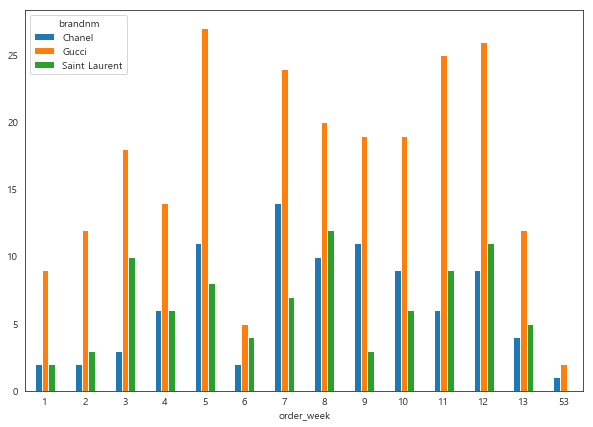

In [472]:
df.query('brandnm=="Saint Laurent"|brandnm=="Gucci"|brandnm=="Chanel"').pivot_table(index='order_week',
columns='brandnm', values='order_date', aggfunc='count').plot.bar(rot=0)

**- 지지도 0.5이상인 ITEMSETS 5건**

지지도 해석 : 동일한 주에 X,Y 모두 대여될 확률

### EDA 2차
1. 2021년 전후로 구분	: 동섭, 낙주
2. 구매건수에 따라 구분 : 재환, 지인
3. 1,2,3월 구매유저로 구분 : 찬서, 준식


1. 구매 소요 시간 분석
    - 가입일로부터 구매일까지 전환된 소요시간 분석 (최근 3개월, 월별 변동사항, 트렌드)
    
    ex. 가입 1일 이내 전환 유저 : 10% -> 15% 상승 성과


2. 구매 상품 트렌드 분석

    2-1. 유저당 주문 수량 분석 (최근 3개월, 월별 변동사항, 트렌드)
    
    2-2. 주문 아이템 분석
        - 브랜드 별 선호도, 아이템 카테고리별 선호도 분석
        - 신규 유저들의 구매 트렌드 파악


3. 분석 내용 토대로 인사이트 도출

    3-1. 분석 내용 도식화
        - 1~2의 분석 내용 종합 및 도식화 (표 또는 그래프)
        - 유사성을 갖는 결과에 대하여 그룹화
    3-2. 인사이트 도출
        - 인사이트 도출 혹은 새로운 제안사항 전달


#### 가입시기 기준 유저 분류 기반


#### 구매건수 기준 유저 분류 기반


In [526]:
# 2건 이상 heavy user로 규정
heavy_list=df_user.query('order_count>1').user.tolist()
df['seg_heavy']=np.where(df.user.isin(heavy_list),1,0)
df_user['seg_heavy']=np.where(df_user.user.isin(heavy_list),1,0)

##### 구매 전환 소요시간 

In [527]:
# 필요 컬럼 생성
# lag : 구매일 - 가입일 간 소요일수 계산
# lag_month : lag를 30일로 나누어 소요월 계산
# order_month : 주문월 표시

df['lag'] = (pd.to_datetime(df['order_date']) - pd.to_datetime(df['reg_date'])).dt.days
df['lag_month'] = df['lag']/30
df['order_month'] = pd.to_datetime(df['order_date']).dt.month
df

,brandnm,goodsnm,user,reg_date,order_date,p_type,sub_type,app_yn,reg_year,reg_month,reg_yearmonth,reg_dayofweek,order_month,order_week,order_dayofweek,brandnm_luxury,seg_new,seg_heavy,lag,lag_month
0,Chanel,pocket graphics pattern zipup-jumper navy,a1112031,2020-08-15,2021-01-01,7days,O,0,2020,08,2020-08,5,1,53,4,1,0,0,139,4.63
1,El estilo de Claire,beads stud velvet jacket black,a196681,2020-04-17,2021-01-01,4days,O,1,2020,04,2020-04,4,1,53,4,0,0,1,259,8.63
2,Baum Und Pferdgarten,geometric pattern A-Line dress purple,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,2020-04,4,1,53,4,0,0,1,259,8.63
3,BCBG,pleats basic pattern H-Line dress deeppink,a196681,2020-04-17,2021-01-01,4days,D,1,2020,04,2020-04,4,1,53,4,0,0,1,259,8.63
4,Balmain,double button long coat white,a1140621,2020-12-31,2021-01-02,7days,O,0,2020,12,2020-12,3,1,53,5,0,0,0,2,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,A.P.C.,half round chain bag black,a129477,2019-06-13,2021-03-31,4days,BA,1,2019,06,2019-06,3,3,13,2,0,0,0,657,21.90
1467,Louis Vuitton,monogram canvas clutch bag,a13741,2018-03-20,2021-03-31,4days,BA,1,2018,03,2018-03,1,3,13,2,1,0,0,1107,36.90
1468,Lucky Chouette,button check pattern shirts multi,a157459,2019-11-21,2021-03-31,4days,T,1,2019,11,2019-11,3,3,13,2,0,0,0,496,16.53
1469,Louis Vuitton,Mogram neonoe bucket brown bag,a174354,2020-01-16,2021-03-31,4days,BA,1,2020,01,2020-01,3,3,13,2,1,0,0,440,14.67


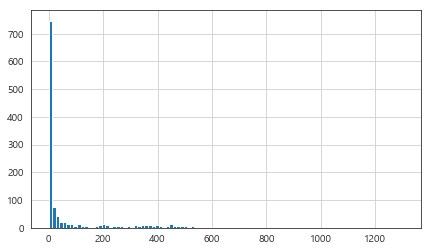

In [486]:
df_user['lag'].hist(bins = 100, figsize=(7,4))

In [528]:
df_user = df_user.merge(df.groupby('user')['lag'].min().reset_index().sort_values(by = 'lag', ascending = False).reset_index(drop=True), 
              on='user', how='left')
df.describe().lag.T

count   1471.00
mean    106.52 
std     206.63 
min     0.00   
25%     1.00   
50%     4.00   
75%     88.00  
max     1304.00
Name: lag, dtype: float64

- 가입한 날에 구매한 고객에 분포 집중

In [578]:
# 가입일로부터 첫주문일까지 걸린 시간 lag_lvl에 6개 분류로 표기
# Sameday : 가입당일 주문 / Nextday : 가입 2일차 주문 / ~1Week : 가입 3일차 ~ 1주일 내 주문
# ~1month :가입 8일차 ~ 1개월 내 주문 / ~1year : 가입 1개월차 ~ 1년 내 주문 / 1year+ : 가입한지 1년 지나서 주문
cut_labels = ['Sameday', '~2Weeks', '~1month', '~1year', '1year+']
cut_bins = [-1, 0, 14, 30, 365, 1304]
df['lag_lvl'] = pd.cut(df['lag'], bins=cut_bins, labels=cut_labels)
df_user['lag_lvl'] = pd.cut(df_user['lag'], bins=cut_bins, labels=cut_labels)

In [634]:
#df_user.filter(regex='user|lag').sort_values('lag', ascending=False)

Text(0.5, 1.0, 'heavy user의 구매수량(x)과 구매전환소요시간')

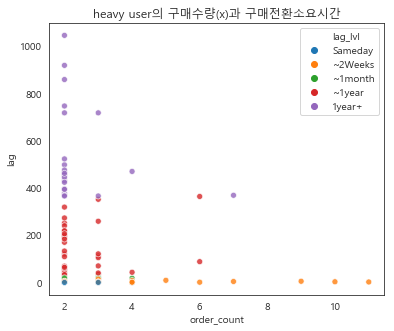

In [632]:
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_user.query('seg_heavy==1'), y='lag', x='order_count', 
                hue='lag_lvl', alpha =0.8)
plt.title('heavy user의 구매수량(x)과 구매전환소요시간')

- 주문 건수 많은 고객 구매 전환 소요시간 2주이상 유저 수 많음
- 1년~ 유저 대부분 1-2 건

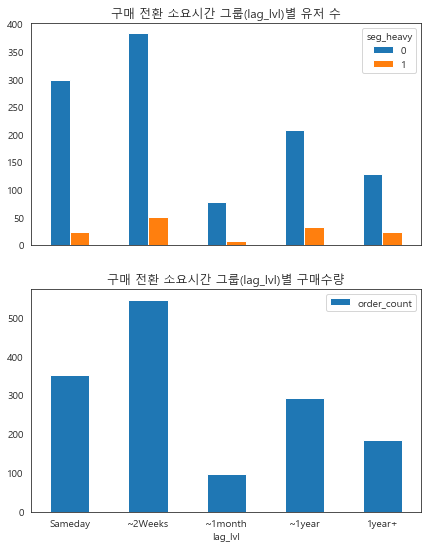

In [630]:
fig, axes = plt.subplots(nrows=2,figsize=(7,9), sharex=True)
df_user.pivot_table(index='lag_lvl', values='user',
                            columns='seg_heavy',
                    aggfunc='count').reset_index().plot(kind='bar', x='lag_lvl',
                                                       rot=0,  ax=axes[0],
                                                   title='구매 전환 소요시간 그룹(lag_lvl)별 유저 수')
df_user.pivot_table(index='lag_lvl',
                   values='order_count', 
                    aggfunc='sum').plot(kind='bar', rot=0, ax=axes[1],
                                         title='구매 전환 소요시간 그룹(lag_lvl)별 구매수량')


##### 📍 insights
1. 가입 2주 이내 유저, 구매수량 많음 & 1년~ 유저 구매수량 대부분 1-2 건
2. 상대적으로 가입 2주 이후-1달 구매 유저 현저히 적음 > 가입 2주안에 구매 쿠폰 제공하면 극대화되지 않을까?

_idea?_
> - 가입일 / 2일-2주 / 1달이내 / 1년이상 (Dormant) 구매전환 segmentation
> - 가입 이벤트 / 클로젯셰어 기존에 진행한 주말&월말 이벤트 / Dormant 유저 대상 이벤트.. (증권사휴면계좌처럼..?)

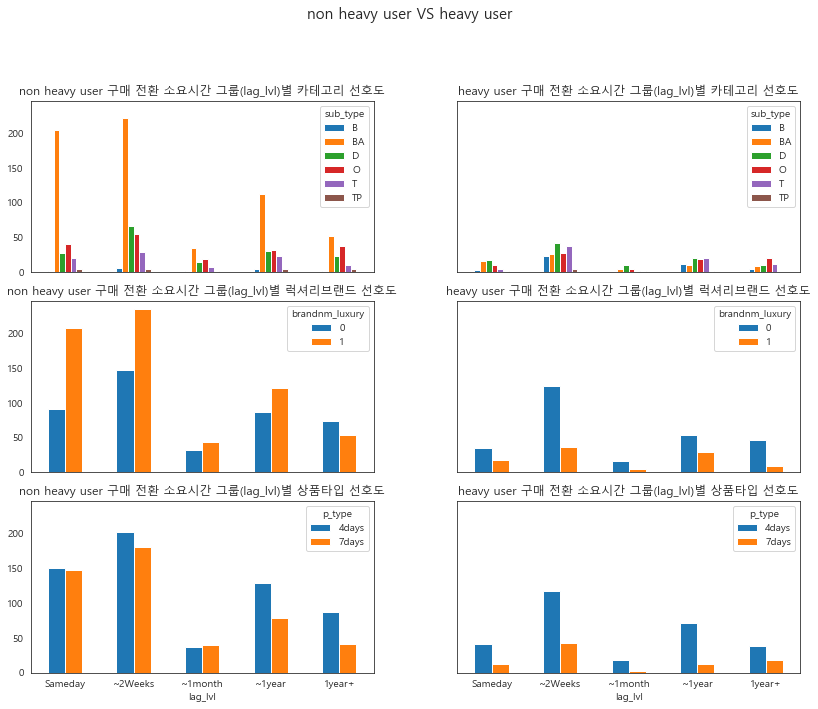

In [644]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), sharex=True, sharey=True)
fig.suptitle('non heavy user VS heavy user', fontsize=15)

df.query('seg_heavy==0').pivot_table(index='lag_lvl',
                    columns='sub_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[0,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(lag_lvl)별 카테고리 선호도')
df.query('seg_heavy==1').pivot_table(index='lag_lvl',
                    columns='sub_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[0,1],
                                         title='heavy user 구매 전환 소요시간 그룹(lag_lvl)별 카테고리 선호도')
df.query('seg_heavy==0').pivot_table(index='lag_lvl',
                    columns='brandnm_luxury',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(lag_lvl)별 럭셔리브랜드 선호도')

df.query('seg_heavy==1').pivot_table(index='lag_lvl',
                    columns='brandnm_luxury',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[1,1],
                                         title='heavy user 구매 전환 소요시간 그룹(lag_lvl)별 럭셔리브랜드 선호도')
df.query('seg_heavy==0').pivot_table(index='lag_lvl',
                    columns='p_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,0],
                                         title='non heavy user 구매 전환 소요시간 그룹(lag_lvl)별 상품타입 선호도')

df.query('seg_heavy==1').pivot_table(index='lag_lvl',
                    columns='p_type',
                   values='user', 
                    aggfunc='count').plot(kind='bar', rot=0, ax=axes[2,1],
                                         title='heavy user 구매 전환 소요시간 그룹(lag_lvl)별 상품타입 선호도')
fig.tight_layout()
fig.subplots_adjust(top=0.85)

##### 📍 insights
1. `heavyuser`그룹으로 갈 수록 bag에 집중도 낮아짐 > heavy user 일수록 더 뚜렷
2. `sameday`그룹 & `nonheavyuser` 럭셔리브랜드 선호
3. 구매전환소요시간 짧은 그룹은 상품타입별 차이 크지 않으나, 긴 그룹 4일권 선호

_idea?_
> - ex 당일 구매 그룹 럭셔리/가방 선호 & 상품타입별 차이 크지 않음 > 7일권 구매시 할인 마케팅 (유도..?)
> - ex 

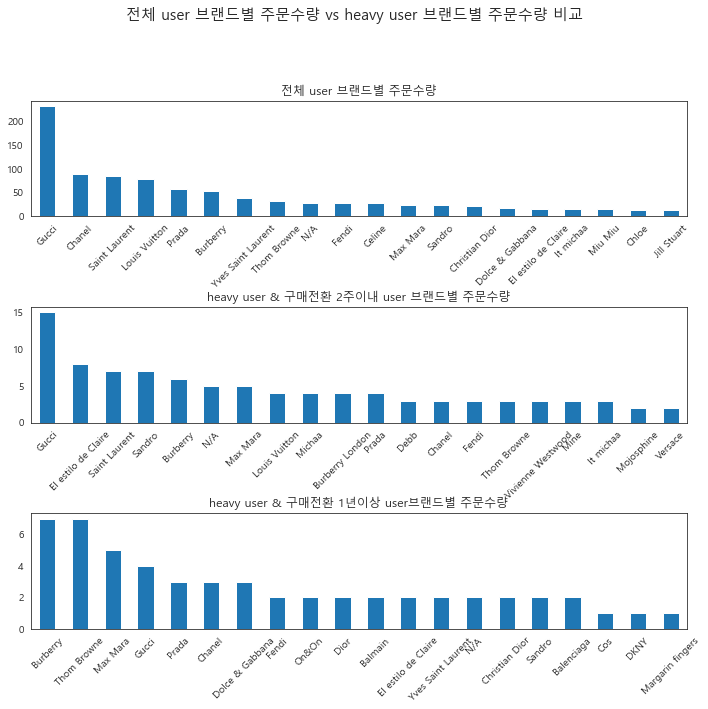

In [663]:
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(10,10))
fig.suptitle('전체 user 브랜드별 주문수량 vs heavy user 브랜드별 주문수량 비교', fontsize=15)
df.brandnm.value_counts().sort_values(ascending=False).head(20).plot.bar(rot=45, title='전체 user 브랜드별 주문수량', ax=axes[0])
df.query('(seg_heavy==1)&((lag_lvl=="Sameday")|(lag_lvl=="~2Weeks"))').brandnm.value_counts().sort_values(ascending=False).head(20).plot.bar(rot=45, title='heavy user & 구매전환 2주이내 user 브랜드별 주문수량', ax=axes[1])
df.query('(seg_heavy==1)&((lag_lvl=="~1year")|(lag_lvl=="~1year+"))').brandnm.value_counts().sort_values(ascending=False).head(20).plot.bar(rot=45, title='heavy user & 구매전환 1년이상 user브랜드별 주문수량', ax=axes[2])

fig.tight_layout()
fig.subplots_adjust(top=0.85)

##### 📍 insights
`heavyuser`그룹내 `lag_lvl(1년이상)` 구분 
1. 브랜드 리스트 차이 존재 (1년이상인 그룹의 카테고리 분포때문? 가방 외 카테고리를 구매해서..?)

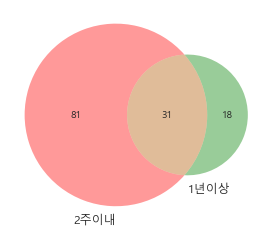

In [662]:
# 신규 유저 vs 기존 유저 주문 브랜드 차이 
plt.figure(figsize=(6,4))
venn2([set(df.query('(seg_heavy==1)&((lag_lvl=="Sameday")|(lag_lvl=="~2Weeks"))').brandnm.value_counts().sort_values(ascending=False).index.tolist()),
       set(df.query('(seg_heavy==1)&((lag_lvl=="~1year")|(lag_lvl=="~1year+"))').brandnm.value_counts().sort_values(ascending=False).index.tolist())],
     set_labels = ('2주이내','1년이상'))
plt.show()

#### 월별 구매유저 분류 기반
